#  In this script I am creating the advanced and latest model named CapsNet for the MNIST digits dataset. The model uses the dynamic routing by agreement algorithm.
-------------------------------------------------------------------------------------------------------------------
# Technology used: TensorFlow

### Start with the usual utility cells

In [1]:
# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# for pickling the data
import cPickle as pickle

# THE TensorFlow framework
import tensorflow as tf
# use the tensorflow's archived version of the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

Data
LICENSE
Literature
Models
README.md
Scripts



In [4]:
# set a seed value for the script
seed_value = 3

In [5]:
np.random.seed(seed_value) # set this seed for a device independant consistent behaviour

In [6]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../Data" # the data path

base_model_path = "../Models"

# constant values for the script
num_digits = 10 # This is defined. There are 10 labels for 10 digits

In [64]:
# Hyper parameters for tweaking.
# ==================================================================================================================
batch_size = 64 # 64 images in each batch
no_of_epochs = 100
checkpoint_factor = 5 # save model after 5 epochs
primary_capsule_length = 8
depthwise_count_of_primary_capsules = 32
conv_lay_kernel_size = 9; conv_lay_stride = 1
conv_lay_num_filters = 256
prim_cap_lay_kernel_size = 9; prim_cap_lay_stride = 2
digit_capsule_length = 16 # Can be tweaked later on
ROUTING_ITERATIONS_COUNT = 3 # no. of routing by agreement iterations
# ==================================================================================================================

In [8]:
mnist_data = input_data.read_data_sets(os.path.join(data_path, "MNIST_data"), reshape=False)

Extracting ../Data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../Data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
train_X = mnist_data.train.images; train_Y = mnist_data.train.labels
dev_X = mnist_data.validation.images; dev_Y = mnist_data.validation.labels
test_X = mnist_data.test.images; test_Y = mnist_data.test.labels

In [10]:
# print all the shapes:
print "Training Data shapes: ", train_X.shape, train_Y.shape
print "Development Data shapes: ", dev_X.shape, dev_Y.shape
print "Test Data shapes: ", test_X.shape, test_Y.shape

Training Data shapes:  (55000, 28, 28, 1) (55000,)
Development Data shapes:  (5000, 28, 28, 1) (5000,)
Test Data shapes:  (10000, 28, 28, 1) (10000,)


In [11]:
# define the total_train_examples:
total_train_examples = train_X.shape[0] # first dimension is the batch dimension
img_dim = train_X.shape[1] # second and third dimensions are height and width
num_channels = train_X.shape[-1] # last dimension is the channels dimension. (Here it is 1)

## Perform random checking of the images to verify if their sanity is maintained

### run the following cell multiple times. 

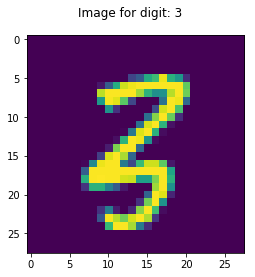

In [19]:
''' Randomized cell: Behaviour changes upon running multiple times '''

random_index = np.random.randint(total_train_examples)

# bring the random image from the training data
random_image = np.squeeze(train_X[random_index], axis = -1)
label_for_random_image = train_Y[random_index]

# display this random image:
plt.figure().suptitle("Image for digit: " + str(label_for_random_image))
plt.imshow(random_image)

It is a great tool that TensorFlow has provided under the examples package. The data setup becomes so easy especially for experimental notebooks. MNIST is one of the most used dataset and is regarded as the 'Drosophila' of Machine Learning by G. Hinton.

# Capsule Network part:

In [118]:
# point to reset the graph if some error occurs below:
tf.reset_default_graph()

define the placeholders for the TensorFlow Computation graph:

In [119]:
with tf.name_scope("Input_data"):
    tf_input_images = tf.placeholder(tf.float32, shape=(None, img_dim, img_dim, num_channels), name="input_images")
    tf_input_labels = tf.placeholder(tf.int32, shape=(None,), name="input_labels")
    
    # attach a summary op for the input_images
    input_images_summary = tf.summary.image("input_images", tf_input_images)

encode the labels into one_hot encoded format:

In [120]:
with tf.name_scope("One_hot_encoder"):
    tf_one_hot_encoded_labels = tf.one_hot(tf_input_labels, depth=num_digits, name="one_hot_encoder")

In [121]:
# check the dimensions of the tf_one_hot_encoded_labels
print "One_hot_encoded labels: ", tf_one_hot_encoded_labels

One_hot_encoded labels:  Tensor("One_hot_encoder/one_hot_encoder:0", shape=(?, 10), dtype=float32)


the shape is as expected. So, we can now move forward

define the first two layers of the CapsNet architecture:

In [122]:
# define the conv layer:
with tf.name_scope("Conv1"):
    conv_lay_out = tf.layers.conv2d(tf_input_images, filters=conv_lay_num_filters, 
                        kernel_size=conv_lay_kernel_size, activation=tf.nn.relu, strides=conv_lay_stride,
                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=seed_value))

In [123]:
# check the shape of the lay_1 outputs
print "lay_1 output volume: ", conv_lay_out

lay_1 output volume:  Tensor("Conv1/conv2d/Relu:0", shape=(?, 20, 20, 256), dtype=float32)


The shape is as expected.

giving due credit -> https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb <br>
I have used the following function from above mentioned repository.

In [124]:
# define the squash function for the primary_caps layer:
def squash(s, axis=-1, epsilon=1e-7, name="squash"):
    '''
        Squash function as the block non-linearity.
    '''
    with tf.name_scope(name, default_name="squash"):
        # obtain the squared norm first
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        
        # add a small epsilon to it to make the compuations stable
        safe_norm = tf.sqrt(squared_norm + epsilon)
        
        # calculate the squash_factor term
        squash_factor = squared_norm / (1. + squared_norm) # note that this term is already stable
        
        # calculate the unit vector
        unit_vector = s / safe_norm
        
        # return the squashed output.
        return squash_factor * unit_vector

In [125]:
# define the primary caps layer:
with tf.name_scope("PrimaryCaps"):
    primary_caps_lay_out = tf.layers.conv2d(conv_lay_out, kernel_size=prim_cap_lay_kernel_size, 
                                strides=prim_cap_lay_stride,
                                filters=(primary_capsule_length * depthwise_count_of_primary_capsules),
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=seed_value))
    
    # reshape the output volume in the form of capsules
    _, h, w, _ = primary_caps_lay_out.get_shape() # extract the height and width of the original volume
    primary_caps_lay_out = tf.reshape(primary_caps_lay_out, 
            shape=(-1, h * w * depthwise_count_of_primary_capsules, primary_capsule_length), name="capsule_maker")
    
    # finally apply the squash function
    primary_caps_lay_out = squash(primary_caps_lay_out)

In [126]:
# check the shape of the primary_caps_lay_out
print "primary_caps_lay output volume: ", primary_caps_lay_out

primary_caps_lay output volume:  Tensor("PrimaryCaps/squash/mul:0", shape=(?, 1152, 8), dtype=float32)


In [127]:
# extract the prev_layer_caps count
_, no_of_primary_layer_caps, _ = primary_caps_lay_out.get_shape()

In [128]:
# define the weights required for the DigitCaps layer:
with tf.name_scope("DigitCaps"):
    with tf.variable_scope("trainable_weights"):
        W = tf.get_variable("capsule_prediction_weights", 
             shape=(1, no_of_primary_layer_caps, num_digits, digit_capsule_length, primary_capsule_length),
             initializer=tf.contrib.layers.xavier_initializer(seed=seed_value))

In [132]:
W

<tf.Variable 'trainable_weights/capsule_prediction_weights:0' shape=(1, 1152, 10, 16, 8) dtype=float32_ref>

In [85]:
# define the digit_caps layer:
''' This is an important cell! This implements the crux of the algorithm: "The dynamic routing algorithm" '''
with tf.name_scope("DigitCaps"):
    # obtain the next_layer's predictions by using the defined weight matrices.
    # tile the primary_caps_lay_out for the matrix multiplication:
    W_tiled = tf.tile(W, multiples=[tf.shape(primary_caps_lay_out)[0], 1, 1, 1, 1])
    print W_tiled
    
    pclo_tiled = tf.tile(tf.expand_dims(tf.expand_dims(primary_caps_lay_out, axis=2), axis=-1), 
                         multiples=[1, 1, num_digits, 1, 1])
    print pclo_tiled
    
    predicted_caps = tf.squeeze(tf.matmul(W_tiled, pclo_tiled), axis=[-1])
    
    # initialize the b values to zero.
    
    
    # Now perform the dynamic routing (iterative process)
    def cond(counter):
        return tf.less(counter, ROUTING_ITERATIONS_COUNT)
    
    def body(counter, b_vals, predicted_caps):
        pass

Tensor("DigitCaps_7/Tile:0", shape=(?, 1152, 10, 16, 8), dtype=float32)
Tensor("DigitCaps_7/Tile_1:0", shape=(?, 1152, 10, 8, 1), dtype=float32)


In [86]:
predicted_caps

<tf.Tensor 'DigitCaps_7/Squeeze:0' shape=(?, 1152, 10, 16) dtype=float32>